Data Extraction (from RAWB file to P2 PGM)

In [ ]:
import struct
import os
# Set the dimensions of the volume
width = 181
height = 217
depth = 181

# Open the input file in binary mode
with open("BrainWeb/t1_icbm_normal_1mm_pn1_rf40.rawb", "rb") as file:
    # Loop through each slice in the volume
    for z in range(depth):
        # Create a new PGM file for the slice
        with open(f'Extracted_files//pgm//t1_icbm_normal_1mm_pn1_rf40//slice_{z}.pgm', "w+") as pgm_file:
            # Write the PGM file header
            pgm_file.write("P2\n")
            pgm_file.write("#\n")
            pgm_file.write(f"{width} {height}\n")
            pgm_file.write("255\n")

            # Loop through each row in the slice
            for y in range(height):
                # Read a row of data from the input file
                row_data = file.read(width)  # Each value is 1 byte
                # Unpack the row data into a list of integers
                values = struct.unpack(f"{width}B", row_data)
                
                # Find the maximum value in the input data
                max_value = max(values)
                
                if max_value == 0:
                    # Handle the case where all values are zero
                    scaled_values = [0] * width
                else:
                    # Scale the values down to the maximum range of 255
                    #scaled_values = [int(v * 255 / max_value) for v in values]
                    scaled_values = [int(v) for v in values]

                # Convert each scaled value to decimal and write it to the PGM file
                pgm_file.write(" ".join([str(v) for v in scaled_values]) + "\n")


PGM to JPG

In [ ]:
from PIL import Image

# Set the input and output directories
input_dir = "Extracted_files/pgm/t1_icbm_normal_1mm_pn1_rf40"
output_dir = "Extracted_files/jpg/t1_icbm_normal_1mm_pn1_rf40"

# Loop through all of the PGM files in the input directory
for file in os.listdir(input_dir):
    if file.endswith(".pgm"):
        # Open the PGM file
        with Image.open(os.path.join(input_dir, file)) as img:
            # Convert the PGM file to a JPEG file
            img.save(os.path.join(output_dir, os.path.splitext(file)[0] + ".jpg"), "JPEG")


Skull-stripping

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def dfs(x, y, data, skull_mask):
    nxt = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
    for (dx, dy) in nxt:
        if 0 <= dx < data.shape[0] and 0 <= dy < data.shape[1] and data[dx, dy] > 0 and not vis[dx][dy]:
            vis[dx][dy] = True
            skull_mask[dx, dy] = True
            dfs(dx, dy, data, skull_mask)

# Input and output folders
input_folder =  'volumes2\\t1_icbm_normal_1mm_pn1_rf40'
output_folder = 'dataset\\t1_icbm_normal_1mm_pn1_rf40\\jpg'

# Ensure output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        try:
            # Read the image
            filepath = os.path.join(input_folder, filename)
            #print("Processing:", filepath)  # Add debug output
            data = io.imread(filepath, as_gray=True).astype(int)


            vis = np.zeros_like(data, dtype=bool)
            skull_mask = np.zeros_like(data, dtype=bool)

            max_count = 0

            for i in range(data.shape[0]):
                for j in range(data.shape[1]):
                    if data[i, j] > 42 and not vis[i][j]:
                        temp_skull_mask = np.zeros_like(data, dtype=bool)
                        stck = [(i, j)]
                        current_count = 0
                        while stck:
                            x, y = stck.pop()
                            temp_skull_mask[x, y] = True
                            current_count += 1
                            nxt = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
                            for (dx, dy) in nxt:
                                if 0 <= dx < data.shape[0] and 0 <= dy < data.shape[1] and data[dx, dy] > 42 and not vis[dx][dy]:
                                    vis[dx][dy] = True
                                    stck.append((dx, dy))
                        if current_count > max_count:
                            max_count = current_count
                            skull_mask = temp_skull_mask

            # Apply skull mask to the original image to obtain the skull region
            skull_image = np.where(skull_mask, data, 0)

            # Save the skull-stripped image to the output folder
            output_filepath = os.path.join(output_folder, filename)
            io.imsave(output_filepath, skull_image.astype(np.uint8))

           # print(f"Processed: {filename}")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("Processing complete.")


JPG to PGM

In [ ]:
import cv2

def jpg_to_p2_pgm(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            # Read the image
            input_file = os.path.join(input_folder, filename)
            img = cv2.imread(input_file, cv2.IMREAD_GRAYSCALE)

            # Write the image in P2 PGM format
            output_file = os.path.join(output_folder, os.path.splitext(filename)[0] + ".pgm")
            with open(output_file, 'w') as f:
                f.write("P2\n")
                f.write("# P2 PGM file\n")
                f.write(f"{img.shape[1]} {img.shape[0]}\n")  # Width and height
                f.write("255\n")  # Maximum gray value
                for row in img:
                    for pixel in row:
                        f.write(f"{pixel} ")
                    f.write("\n")

# Example usage:
input_folder = 'dataset\\t1_icbm_normal_1mm_pn0_rf0\\jpg'
output_folder = 'dataset\\t1_icbm_normal_1mm_pn0_rf0\\pgm'
jpg_to_p2_pgm(input_folder, output_folder)


Import Libraries

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import numpy as np


set training, validation and test split percentage

In [2]:
tr=20
v=40
te=40

set noise and INU

In [3]:
pn=9
rf=20

split and make folders for training, validation and testing

In [4]:

def split_dataset(image_dir, gt_dir, test_size, val_size, random_state):
    # Get list of image filenames
    image_filenames = sorted(os.listdir(image_dir))
    
    # Get corresponding list of ground truth filenames
    gt_filenames = sorted(os.listdir(gt_dir))
    
    # Split filenames into train and test sets
    image_filenames_trainval, image_filenames_test, gt_filenames_trainval, gt_filenames_test = train_test_split(
        image_filenames, gt_filenames, test_size=test_size, random_state=random_state)
    
    # Further split trainval set into train and validation sets
    image_filenames_train, image_filenames_val, gt_filenames_train, gt_filenames_val = train_test_split(
        image_filenames_trainval, gt_filenames_trainval, test_size=val_size/(1-test_size), random_state=random_state)
    
    return (image_filenames_train, gt_filenames_train), (image_filenames_val, gt_filenames_val), (image_filenames_test, gt_filenames_test)

# Example usage:
image_dir = rf"dataset\\t1_icbm_normal_1mm_pn{pn}_rf{rf}\\pgm"
gt_dir = r"phantom_1.0mm_normal_crisp"
test_size = te/100
val_size = v/100
random_state = 42  # Random seed for reproducibility

# Split dataset into training, validation, and testing sets
(train_files, train_gt_files), (val_files, val_gt_files), (test_files, test_gt_files) = split_dataset(image_dir, gt_dir, test_size, val_size, random_state)

train_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/train'
val_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/validation'
test_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/test'
train_gt_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/train_masks'
val_gt_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/validation_masks'
test_gt_dir = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/test_masks'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_gt_dir, exist_ok=True)
os.makedirs(val_gt_dir, exist_ok=True)
os.makedirs(test_gt_dir, exist_ok=True)

# Copy train files to train directory
for file_name, gt_file_name in zip(train_files, train_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(train_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(train_gt_dir, gt_file_name))

# Copy validation files to validation directory
for file_name, gt_file_name in zip(val_files, val_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(val_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(val_gt_dir, gt_file_name))

# Copy test files to test directory
for file_name, gt_file_name in zip(test_files, test_gt_files):
    shutil.copyfile(os.path.join(image_dir, file_name), os.path.join(test_dir, file_name))
    shutil.copyfile(os.path.join(gt_dir, gt_file_name), os.path.join(test_gt_dir, gt_file_name))

# Display the number of files in each split
print("Number of training files:", len(train_files))
print("Number of validation files:", len(val_files))
print("Number of testing files:", len(test_files))


Number of training files: 9
Number of validation files: 21
Number of testing files: 21


In [5]:
train=len(train_files)
val=len(val_files)
test=len(test_files)

function for read PGM files and normalize pixel intensities

In [6]:

def read_pgm(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
        max_value = max(pixel_values)
        # print(max_value)
         # Normalize pixel values to range [0, 1]
        pixel_values = [value / max_value for value in pixel_values]

        return pixel_values

def read_pgm_files_from_folder(folder_path):
    """
    Reads all PGM files from a folder and returns their data as a list of pixel value lists.
    """
    pgm_files_pixel_values = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.pgm'):
            file_path = os.path.join(folder_path, filename)
            pixel_values = read_pgm(file_path)
            pgm_files_pixel_values.append(pixel_values)
    return pgm_files_pixel_values




In [7]:
# Example usage:
#folder_path = 'volumes/t1_icbm_normal_1mm_pn0_rf0/train'
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/train'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"train_pixel_values_{i}"] = pixel_values

In [8]:
# Example usage:
#folder_path = 'volumes/t1_icbm_normal_1mm_pn0_rf0/train'
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/validation'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"val_pixel_values_{i}"] = pixel_values

In [9]:
# Example usage:
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/test'
pgm_files_pixel_values = read_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"test_pixel_values_{i}"] = pixel_values


function for read PGM files for groundtruth images

In [10]:

def read_pgm_mask(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
       # Convert pixel values greater than 3 to 0
        pixel_values = [0 if pixel > 3 else pixel for pixel in pixel_values]

        return pixel_values

def read_mask_pgm_files_from_folder(folder_path):
    """
    Reads all PGM files from a folder and returns their data as a list of pixel value lists.
    """
    pgm_files_pixel_values = []
    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith('.pgm'):
            file_path = os.path.join(folder_path, filename)
            pixel_values = read_pgm_mask(file_path)
            pgm_files_pixel_values.append(pixel_values)
    return pgm_files_pixel_values




In [11]:
# Example usage:
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/train_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"train_mask_pixel_values_{i}"] = pixel_values
    


In [12]:
# Example usage:
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/validation_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"val_mask_pixel_values_{i}"] = pixel_values
    


In [13]:
# Example usage:
folder_path = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/test_masks'
pgm_files_pixel_values = read_mask_pgm_files_from_folder(folder_path)

# Access pixel values using different lists
for i, pixel_values in enumerate(pgm_files_pixel_values):
    locals()[f"test_mask_pixel_values_{i}"] = pixel_values
    

Create X_train and y_train

In [14]:
height = 217
width = 181

X_train = []
y_train = []

for t in range(train):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    train_pixel_values_t = locals().get(f'train_pixel_values_{t}', None)
    if train_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    train_mask_pixel_values_t = locals().get(f'train_mask_pixel_values_{t}', None)
    if train_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(train_pixel_values_t[k])
            X_train.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_train.append(train_mask_pixel_values_t[l])
            l += 1
            
print(len(X_train))
print(len(y_train))

353493
353493


Create X_val and y_val

In [15]:

X_val = []
y_val = []

for t in range(val):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    val_pixel_values_t = locals().get(f'val_pixel_values_{t}', None)
    if val_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    val_mask_pixel_values_t = locals().get(f'val_mask_pixel_values_{t}', None)
    if val_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(val_pixel_values_t[k])
            X_val.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_val.append(val_mask_pixel_values_t[l])
            l += 1
            
print(len(X_val))
print(len(y_val))

824817
824817


Create X_test and y_test

In [16]:
X_test = []
y_test = []

for t in range(test):
    k = 0  # Reset the index for each file
    l = 0  # Reset the index for each file
    
    # Load pixel values for the current file
    test_pixel_values_t = locals().get(f'test_pixel_values_{t}', None)
    if test_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    # Load mask pixel values for the current file
    test_mask_pixel_values_t = locals().get(f'test_mask_pixel_values_{t}', None)
    if test_mask_pixel_values_t is None:
        continue  # Skip if data for current file is not found
    
    for i in range(width):
        for j in range(height):
            rows = []
            rows.append(test_pixel_values_t[k])
            X_test.append(rows)
            k += 1
            
    for i in range(width):
        for j in range(height):
            y_test.append(test_mask_pixel_values_t[l])
            l += 1
            
print(len(X_test))
print(len(y_test))






824817
824817


Standardize dataset

In [17]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [18]:
print(len(X_train_scaled))
print(len(y_train))

353493
353493


convert to numpy arrays

In [19]:

X_train=np.array(X_train_scaled)
X_val=np.array(X_val_scaled)
X_test=np.array(X_test_scaled)
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [20]:
X_train.shape


(353493, 1)

In [21]:
X_test.shape

(824817, 1)

Training a RBFNN model

In [23]:
from tensorflow.keras.layers import Dense

# Define the RBF activation function
def rbf(x, beta, centers):
    return tf.exp(-beta * tf.reduce_sum((tf.expand_dims(x, axis=1) - centers)**2, axis=2))

# Define the RBF layer
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, beta_initializer='uniform', **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.beta_initializer = beta_initializer
        
    def build(self, input_shape):
        self.centers = self.add_weight(name='centers', shape=(self.units, input_shape[1]),
                                        initializer='uniform', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(self.units,),
                                    initializer=self.beta_initializer, trainable=True)
        
    def call(self, inputs):
        return rbf(inputs, self.beta, self.centers)

# Define your data and split it into X_train, X_val, X_test, y_train, y_val, y_test

# Define the RBF neural network model
model = tf.keras.Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)), # Input layer
    RBFLayer(10),  # RBF hidden layer
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


c:\Users\Shruti Pathak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 181s 16ms/step - loss: 0.2915 - val_loss: 0.0967
Epoch 2/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 166s 15ms/step - loss: 0.0933 - val_loss: 0.0960
Epoch 3/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 202s 18ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 4/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 217s 14ms/step - loss: 0.0902 - val_loss: 0.0936
Epoch 5/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 167s 15ms/step - loss: 0.0898 - val_loss: 0.0934
Epoch 6/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 187s 14ms/step - loss: 0.0888 - val_loss: 0.0916
Epoch 7/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 169s 15ms/step - loss: 0.0871 - val_loss: 0.0904
Epoch 8/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 182s 16ms/step - loss: 0.0867 - val_loss: 0.0899
Epoch 9/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 182s 16ms/step - loss: 0.0871 - val_loss: 0.0902
Epoch 10/10
11047/11047 ━━━━━━━━━━━━━━━━━━━━ 175s 16ms/step - loss: 0.0865 - val_loss: 0.0902


Calculate loss on test data

In [24]:

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# # Specify the full path to the accuracy.txt file
# file_path = f'E:/Shruti/dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}/accuracy.txt'

# # Open the file in write mode
# with open(file_path, 'w') as f:
#     # Write the evaluation result to the file
#     f.write(f'Report for dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}\n')
#     f.write(f'Loss: {loss:.4f}\n')



25776/25776 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - loss: 0.0736


Predict on test data


In [25]:

y_pred = model.predict(X_test)


25776/25776 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step


In [26]:
y_pred.shape

(824817, 1)

Round the predictions to the nearest integer to get the predicted class and calculate accuracy

In [27]:
from sklearn.metrics import accuracy_score

# Round the predictions to the nearest integer to get the predicted class
y_pred_class = np.round(y_pred).astype(int)

# Convert the ground truth labels to integer format if necessary
y_true_class = y_test.astype(int)

# Calculate accuracy score
accuracy = accuracy_score(y_true_class, y_pred_class)
print("Accuracy Score:", accuracy)



Accuracy Score: 0.9043775770867962


Calculate the classification report

In [28]:

#  Calculate the classification report
report = classification_report(y_true_class, y_pred_class, digits=4)


print(report)

# # Open the file in append mode
# with open(file_path, 'a') as f:
#     # Write the classification report to the file
#     f.write('\nClassification Report:\n')
#     f.write(report)

              precision    recall  f1-score   support

           0     0.9667    0.9807    0.9737    422538
           1     0.7185    0.6368    0.6752     54675
           2     0.8433    0.8090    0.8258    171843
           3     0.8626    0.8975    0.8797    175761

    accuracy                         0.9044    824817
   macro avg     0.8478    0.8310    0.8386    824817
weighted avg     0.9024    0.9044    0.9030    824817



Function for calculating dice coefficients for each class

In [29]:
def dice(im1,im2,cl):
    tp=0
    fp=0
    fn=0
    for i in range(len(im1)):
        if(im1[i]==cl and im2[i]==cl):
            tp+=1
        if(im1[i]==cl):
            fn+=1
        if(im2[i]==cl):
            fp+=1
    return (2*tp/(fp+fn))



In [30]:
class_ids = [0, 1, 2, 3]  # Assuming class IDs range from 0 to 3
dice_coefficients = []

for class_id in class_ids:
    class_dice = dice(y_true_class, y_pred_class, class_id)
    dice_coefficients.append(class_dice)
    print(f"Dice coefficient for class {class_id}: {class_dice}")

mean_dice = sum(dice_coefficients) / len(dice_coefficients)
print(f"Mean Dice coefficient: {mean_dice}")

# # Open the file in append mode
# with open(file_path, 'a') as f:
#     # Write Dice coefficients to the file
#     f.write('\nDice Coefficients:\n')
#     for class_id, class_dice in zip(class_ids, dice_coefficients):
#         f.write(f"Class {class_id} Dice coefficient: {class_dice}\n")
#     # Write mean Dice coefficient to the file
#     f.write(f"Mean Dice coefficient: {mean_dice}\n")



Dice coefficient for class 0: 0.9736510062383251
Dice coefficient for class 1: 0.6751803583895741
Dice coefficient for class 2: 0.8257674761203251
Dice coefficient for class 3: 0.8796691836666406
Mean Dice coefficient: 0.8385670061037163


Testing with an image

In [31]:
def read_pgm_normalized(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
        max_value = max(pixel_values)
        print(max_value)
         # Normalize pixel values to range [0, 1]
        pixel_values = [value / max_value for value in pixel_values]

        return pixel_values

# Example usage:
filename = f'dataset_{tr}_{v}_{te}\\t1_icbm_normal_1mm_pn{pn}_rf{rf}\\test\\slice_80.pgm'
pixel_values_original = read_pgm_normalized(filename)

print(pixel_values_original)
print(max(pixel_values_original))

166
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [32]:
def read_pgm(filename):
    """
    Reads a PGM file and returns the image data as a 2D list.
    """
    with open(filename, 'rb') as f:
        # Skip comments
        magic_number = f.readline().strip()
        if magic_number != b'P2':
            raise ValueError("Not a PGM file")
        while True:
            line = f.readline().decode('utf-8').strip()
            if not line.startswith('#'):
                break

        # Read the header
        width, height = map(int, line.split())
        max_val = int(f.readline())

        # Read the image data
        pixel_values = []
        for _ in range(height):
            row = map(int, f.readline().split())
            pixel_values.extend(row)
            
        # Convert pixel values greater than 3 to 0
        pixel_values = [0 if pixel > 3 else pixel for pixel in pixel_values]

        return pixel_values

filename_mask='phantom_1.0mm_normal_crisp\\slice_80.pgm'
pixel_values_mask = read_pgm(filename_mask)

print(pixel_values_mask)
print(max(pixel_values_mask))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [33]:
height = 217
width = 181


In [34]:
import matplotlib.pyplot as plt

def convert_to_2d_list(lst, rows, cols):
    if len(lst) != rows * cols:
        raise ValueError("Length of the 1D list does not match the specified dimensions of the 2D list.")
    #print(rows)
    #print(cols)
    return [lst[i*cols:(i+1)*cols] for i in range(rows)]

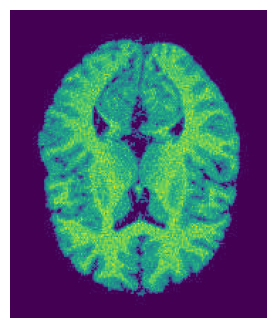

In [35]:
original = convert_to_2d_list(pixel_values_original, height, width)
plt.figure(figsize=(4, 4))  # Set the size of the figure
plt.axis('off')  # Turn off the axis
plt.imshow(original)

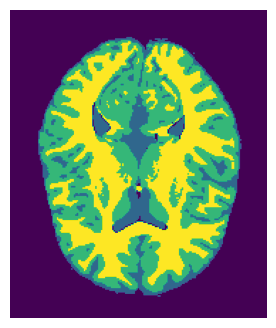

In [36]:
mask = convert_to_2d_list(pixel_values_mask, height, width)
plt.figure(figsize=(4, 4))  # Set the size of the figure
plt.axis('off')  # Turn off the axis
plt.imshow(mask)

In [37]:

X_test=[]
k=0
for i in range(width):
    for j in range(height):
        rows=[]
        rows.append(pixel_values_original[k])
        X_test.append(rows)
        k+=1
        
        
y_test=[]
k=0
for i in range(width):
    for j in range(height):
        y_test.append(pixel_values_mask[k])
        k+=1
scaler = StandardScaler() 
scaler.fit(X_test)
       
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled)
print(y_test)

[[-0.92956675]
 [-0.92956675]
 [-0.92956675]
 ...
 [-0.92956675]
 [-0.92956675]
 [-0.92956675]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [38]:
X_test=np.array(X_test_scaled)
y_test=np.array(y_test)

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test data
y_pred = model.predict(X_test)



1228/1228 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


In [40]:
from sklearn.metrics import accuracy_score

# Round the predictions to the nearest integer to get the predicted class
y_pred_class = np.round(y_pred).astype(int)

# Convert the ground truth labels to integer format if necessary
y_true_class = y_test.astype(int)

# Calculate accuracy score
accuracy = accuracy_score(y_true_class, y_pred_class)
print("Accuracy Score:", accuracy)



Accuracy Score: 0.8882042925885378


In [42]:
import os

# Define the directory path
directory = f'dataset_{tr}_{v}_{te}/t1_icbm_normal_1mm_pn{pn}_rf{rf}'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)



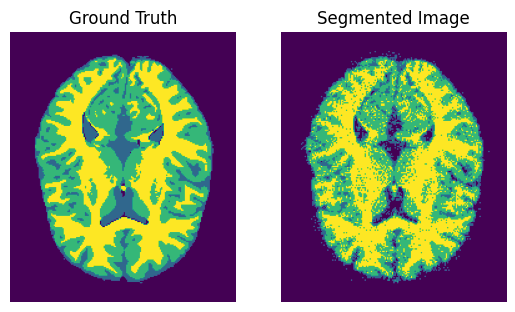

In [43]:
#print the ground truth and the segmented image

original = convert_to_2d_list(y_true_class, height, width)
predicted = convert_to_2d_list(y_pred_class, height, width)

# Plotting original and predicted images
plt.subplot(1, 2, 1)  
plt.imshow(original)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 2, 2)  
plt.imshow(predicted)
plt.title('Segmented Image')
plt.axis('off')

# Save the plot
plt.savefig(os.path.join(directory, 'original_vs_predicted.png'))

# Display the plot
plt.show()

In [46]:
ori_csf=[]
pred_csf=[]

for i in y_true_class:
    if(i==1):
        ori_csf.append(255)
    else:
        ori_csf.append(0)

for i in y_pred_class:
    if(i==1):
        pred_csf.append(255)
    else:
        pred_csf.append(0)

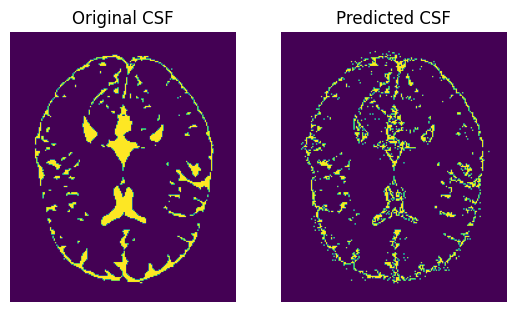

In [47]:
original_csf = convert_to_2d_list(ori_csf, height, width)
predicted_csf = convert_to_2d_list(pred_csf, height, width)

# Plotting original image
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and this being the first subplot
plt.imshow(original_csf)
plt.title('Original CSF')
plt.axis('off')

# Plotting predicted image
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and this being the second subplot
plt.imshow(predicted_csf)
plt.title('Predicted CSF')
plt.axis('off')

# Save the plot
plt.savefig(os.path.join(directory, 'original_csf_vs_predicted_csf.png'))

# Display the plot
plt.show()

In [48]:
ori_gm=[]
pred_gm=[]

for i in y_true_class:
    if(i==2):
        ori_gm.append(255)
    else:
        ori_gm.append(0)

for i in y_pred_class:
    if(i==2):
        pred_gm.append(255)
    else:
        pred_gm.append(0)

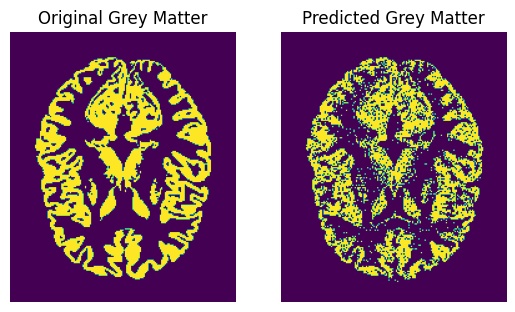

In [49]:
original_gm = convert_to_2d_list(ori_gm, height, width)
predicted_gm = convert_to_2d_list(pred_gm, height, width)

# Plotting original image
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and this being the first subplot
plt.imshow(original_gm)
plt.title('Original Grey Matter')
plt.axis('off')

# Plotting predicted image
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and this being the second subplot
plt.imshow(predicted_gm)
plt.title('Predicted Grey Matter')
plt.axis('off')
# Save the plot
plt.savefig(os.path.join(directory, 'original_gm_vs_predicted_gm.png'))

# Display the plot
plt.show()


In [50]:
ori_wm=[]
pred_wm=[]

for i in y_true_class:
    if(i==3):
        ori_wm.append(255)
    else:
        ori_wm.append(0)

for i in y_pred_class:
    if(i==3):
        pred_wm.append(255)
    else:
        pred_wm.append(0)

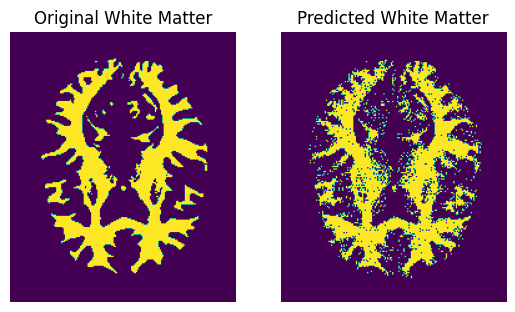

In [51]:
original_wm = convert_to_2d_list(ori_wm, height, width)
predicted_wm = convert_to_2d_list(pred_wm, height, width)

# Plotting original image
plt.subplot(1, 2, 1)  # Subplot with 1 row, 2 columns, and this being the first subplot
plt.imshow(original_wm)
plt.title('Original White Matter')
plt.axis('off')

# Plotting predicted image
plt.subplot(1, 2, 2)  # Subplot with 1 row, 2 columns, and this being the second subplot
plt.imshow(predicted_wm)
plt.title('Predicted White Matter')
plt.axis('off')
# Save the plot
plt.savefig(os.path.join(directory, 'original_wm_vs_predicted_wm.png'))

# Display the plot
plt.show()